Autor: Natalia Kiełbasa

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Mini-projekt (DP): „Co zmienia optymalną politykę i wartość startu?”

### Kontekst
W rozdziale 4 zrobiliśmy Dynamic Programming dla tablicowych MDP:
- mamy **model** środowiska w postaci `P[s][a] = [(p, s2, r, terminated), ...]`,
- umiemy liczyć:
  - `v_π` (policy evaluation),
  - poprawiać politykę (policy improvement),
  - znajdować optimum: `π*`, `v*` (policy iteration / value iteration).

W tym mini-projekcie wykonasz **krótkie badanie**: jak zmiana parametrów środowiska lub zadania wpływa na:
- `v*(start)` — wartość stanu startowego,
- oraz (opcjonalnie) kształt polityki `π*` (strzałki).

---

## Co to jest `v(start)` w skrócie (potem rozwinięte, jeśli ktoś potrzebuje)?
`v(start)` to wartość funkcji wartości w stanie startowym:

$
v(start) = V_\pi(s_{\text{start}})
$

czyli oczekiwana (zdyskontowana) suma nagród, gdy startujesz w `start` i działasz według polityki `π`.
W praktyce to jedna liczba odpowiadająca na pytanie:

> **„Jak dobry jest ten sposób działania, jeśli startuję z typowego stanu startowego?”**

---

## Zadanie (obowiązkowe)
Twoim celem jest wykonać **eksperyment + analizę** (badanie). Zrób to w krokach:

### Krok 1 — wybierz środowisko
Wybierz jedno (albo zrób oba jako bonus):
- FrozenLake (`P_fl_det` lub `P_fl_slip`) — epizodyczne (Start - Goal, pamiętacie?:) ),
- Gridworld (`P_gw` lub większy Gridworld, jeśli jest w notebooku) — continuing (jak wyżej :) ).

Ustal `start_state` (zwykle `0`).
 v(start) to jedna liczba, która pozwala porównywać eksperymenty.
Musisz więc wskazać z jakiego stanu startujesz.

### Krok 2 — policz optimum (punkt odniesienia)
Policz `π*` i `v*` metodą DP:
- `value_iteration(...)` lub `policy_iteration(...)`.

Zapisz `v*(start)`.

### Krok 3 — wybierz 2 pytania badawcze i wykonaj eksperymenty
Wybierz **dwa** pytania z listy poniżej i wykonaj pomiary (sweep parametrów).

### Krok 4 — zrób wykresy
Dla każdego pytania przygotuj co najmniej **1 wykres**.
Minimalnie: wykres parametru (X) → `v*(start)` (Y).

### Krok 5 — opisz wnioski (krótko, ale konkretnie)
Napisz 4–8 zdań:
- co zmieniałeś,
- co zmierzyłeś,
- co wyszło i dlaczego (intuicja + odniesienie do definicji Bellmana).

---

## Pytania badawcze (wybierz 2)

### Pytanie A — wpływ `γ` (gamma)
**Hipoteza do sprawdzenia:** większe `γ` zwiększa znaczenie przyszłości i zmienia `v*(start)` oraz czasem politykę.

Zrób sweep po `γ`, np. `[0.8, 0.9, 0.95, 0.99]`.
Dla każdego `γ` policz `v*(start)`.

**Wykres:** `γ` vs `v*(start)`.

---

### Pytanie B — deterministyczne vs slippery (FrozenLake)
**Hipoteza do sprawdzenia:** stochastyczność (`slippery=True`) obniża `v*(start)` i może zmienić `π*`.

Porównaj:
- `P_fl_det` vs `P_fl_slip` (dla tego samego `γ`).

**Wykres:** dwa punkty/kolumny (det vs slippery) dla `v*(start)` (albo dwa przebiegi vs γ).

---

### Pytanie C — wpływ kar/nagród w Gridworld
**Hipoteza do sprawdzenia:** większe kary za ścianę lub mniejsze nagrody teleportów zmieniają `v*` i „kierunek” polityki.

Zrób sweep po jednym parametrze środowiska (jeśli masz builder świata):
- `wall_penalty ∈ {-1, -2, -5}`,
- lub nagrody teleportów (np. zmniejsz/zwieksz).

**Wykres:** parametr vs `v*(start)`.

---

### Pytanie D — PI vs VI jako metody numeryczne
**Hipoteza do sprawdzenia:** PI ma mniej iteracji „zewnętrznych”, a VI robi więcej prostych backupów.

Zmierz czas działania (np. `time.time()`) dla PI i VI na tym samym środowisku.

**Wykres:** słupki czasu (PI vs VI) lub liczba iteracji (jeśli zapisujesz liczbę iteracji).

> Uwaga: polityki mogą się różnić w stanach z remisami, ale `v*` powinno być takie samo (w granicach numeryki).

---

## Krok 1 - wybór środowiska - FrozenLake

In [2]:
# Dodanie potrzebnych metod

def pretty_matrix_as_grid(v: np.ndarray, nrow: int, ncol: int, decimals: int = 1):
    """Wyświetla wektor wartości jako siatkę nrow x ncol."""
    grid = np.asarray(v, dtype=float).reshape(nrow, ncol)
    with np.printoptions(precision=decimals, suppress=True):
        print(grid)

def action_arrows(pi_det: np.ndarray, nrow: int, ncol: int, arrows):
    """Wyświetla deterministyczną politykę jako strzałki w siatce."""
    out = []
    for r in range(nrow):
        row = []
        for c in range(ncol):
            s = r * ncol + c
            a = int(pi_det[s])
            row.append(arrows.get(a, '?'))
        out.append(' '.join(row))
    print('\n'.join(out))


def build_P_r_for_policy(P, pi: np.ndarray):
    """Buduje (P_pi, r_pi) dla danej polityki pi na podstawie modelu P[s][a].

    Zwraca:
    - P_pi: macierz przejść (nS x nS)
    - r_pi: wektor nagród oczekiwanych (nS,)

    Uwaga: dla zadań epizodycznych (FrozenLake) działa poprawnie, o ile stany terminalne są absorbujące
    z nagrodą 0 (tak jest w standardowym FrozenLake).
    """
    nS, nA = pi.shape
    P_pi = np.zeros((nS, nS), dtype=float)
    r_pi = np.zeros(nS, dtype=float)

    for s in range(nS):
        for a in range(nA):
            w = float(pi[s, a])
            if w == 0.0:
                continue
            for (p, s2, r, terminated) in P[s][a]:
                P_pi[s, int(s2)] += w * float(p)
                r_pi[s] += w * float(p) * float(r)
    return P_pi, r_pi


def evaluate_policy_linear_system(P_pi: np.ndarray, r_pi: np.ndarray, gamma: float) -> np.ndarray:
    """Dokładna ewaluacja polityki przez układ liniowy: (I - gamma P_pi) v = r_pi."""
    nS = P_pi.shape[0]
    I = np.eye(nS)
    return np.linalg.solve(I - gamma * P_pi, r_pi)


def build_frozenlake_P(desc, is_slippery: bool = False):
    """
    Buduje model FrozenLake w formacie P[s][a] bez użycia Gym.

    desc: lista stringów opisujących mapę, np.
          ["SFFF",
           "FHFH",
           "FFFH",
           "HFFG"]

    Konwencja akcji (jak w Gym):
      0 = LEFT, 1 = DOWN, 2 = RIGHT, 3 = UP

    Nagroda:
      +1 za wejście na G, w pozostałych przypadkach 0.

    Stany terminalne:
      H (hole) i G (goal).
    """

    # Zamieniamy opis mapy na tablicę znaków
    desc = np.asarray([list(row) for row in desc], dtype='<U1')
    nrow, ncol = desc.shape
    nS, nA = nrow * ncol, 4   # liczba stanów i akcji

    # Indeksy akcji (zgodne z Gym)
    LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

    # Wektory ruchu dla każdej akcji
    moves = {
        LEFT:  (0, -1),
        DOWN:  (1,  0),
        RIGHT: (0,  1),
        UP:    (-1, 0),
    }

    # Zamiana (r, c) -> indeks stanu
    def to_s(r, c):
        return r * ncol + c

    # Jeden krok z pozycji (r, c) dla akcji a
    def step_from(r, c, a):
        dr, dc = moves[a]
        r2, c2 = r + dr, c + dc

        # FrozenLake: wyjście poza planszę = zostajemy w miejscu
        if (r2 < 0) or (r2 >= nrow) or (c2 < 0) or (c2 >= ncol):
            r2, c2 = r, c

        return r2, c2

    # Inicjalizacja struktury P[s][a]
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    # Iterujemy po wszystkich polach planszy
    for r in range(nrow):
        for c in range(ncol):
            s = to_s(r, c)
            tile = desc[r, c]

            # Stany terminalne (H i G):
            # są absorbujące — niezależnie od akcji zostajemy w tym samym stanie
            if tile in ('H', 'G'):
                for a in range(nA):
                    P[s][a] = [(1.0, s, 0.0, True)]
                continue

            # Stany nieterminalne
            for a in range(nA):
                outcomes = []

                # Wersja śliska: akcja nie realizuje się dokładnie
                if is_slippery:
                    # Faktyczna akcja to a-1, a, a+1 z prawd. 1/3
                    candidates = [(a - 1) % 4, a, (a + 1) % 4]
                    probs = [1/3, 1/3, 1/3]
                else:
                    # Wersja deterministyczna
                    candidates = [a]
                    probs = [1.0]

                # Dla każdej możliwej „rzeczywistej” akcji
                for a_real, p in zip(candidates, probs):
                    r2, c2 = step_from(r, c, a_real)
                    s2 = to_s(r2, c2)
                    tile2 = desc[r2, c2]

                    # Sprawdzamy, czy trafiliśmy w stan terminalny
                    terminated = tile2 in ('H', 'G')

                    # Nagroda tylko za wejście na G
                    reward = 1.0 if tile2 == 'G' else 0.0

                    outcomes.append((float(p), int(s2), float(reward), bool(terminated)))

                # Scalanie identycznych następstw
                # (różne a_real mogą prowadzić do tego samego s2)
                merged = {}
                for p, s2, rwd, term in outcomes:
                    key = (s2, rwd, term)
                    merged[key] = merged.get(key, 0.0) + p

                # Finalna lista wyników dla (s, a)
                P[s][a] = [
                    (p, s2, rwd, term)
                    for (s2, rwd, term), p in merged.items()
                ]

    return P, nS, nA, nrow, ncol, desc

In [10]:
# Inicjalizacja FrozenLake (P_fl_det):

# FrozenLake 4x4 (episodic)
desc4 = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG",
]
P_fl_det, nS_fl, nA_fl, nrow_fl, ncol_fl, desc_fl = build_frozenlake_P(desc4, is_slippery=False)
print('FrozenLake: nS=', nS_fl, ' nA=', nA_fl, ' shape=', (nrow_fl, ncol_fl))
print('FrozenLake map:')
print('\n'.join(''.join(row) for row in desc_fl))

# Mapy akcji -> strzałki (do wizualizacji polityk)
arrows_fl = {0:'←', 1:'↓', 2:'→', 3:'↑'}  # FrozenLake: LEFT, DOWN, RIGHT, UP


FrozenLake: nS= 16  nA= 4  shape= (4, 4)
FrozenLake map:
SFFF
FHFH
FFFH
HFFG


In [11]:
# Ustalamy wstępne start_state
start_state = 0

## Krok 2 - policzenie optimum

In [ ]:
# Implementacja funkcji greedy_policy_from_v na podstawie drugiego notebooka

def greedy_policy_from_v(P, v: np.ndarray, gamma: float = 0.9) -> np.ndarray:
    """Zachłanna poprawa polityki (policy improvement).

    (Ćwiczenie 2)
    Zaimplementuj funkcję, która dla danego `v` buduje politykę deterministyczną `pi_det`:
        pi_det[s] = argmax_a Q(s,a)

    gdzie:
        Q(s,a) = E[ r + gamma * v(s') ]

    Wymagania:
    - zwróć `pi_det` jako wektor intów o kształcie (nS,)
    - użyj pełnego modelu: przejścia są w `P[s][a]` jako (p, s2, r, terminated)
    - obsłuż `terminated` identycznie jak w policy evaluation:
        jeśli `terminated=True`, bootstrap = 0

    Wskazówki:
    - pętla po stanach `s`, wewnątrz pętla po akcjach `a`
    - dla każdej akcji policz `q` jako sumę po wpisach w `P[s][a]`

    Wejście:
    - P: model środowiska w postaci P[s][a] = [(p, s2, r, terminated), ...]
    - v: wektor wartości stanów (np. v_pi), shape (nS,)
    - gamma: współczynnik dyskontowania

    Wyjście:
    - pi_det: deterministyczna polityka, shape (nS,),
              pi_det[s] to indeks najlepszej akcji w stanie s.

    Co robimy:
    - Dla każdego stanu s liczymy Q(s,a) dla wszystkich akcji a,
      używając aktualnego v jako przybliżenia "przyszłości".
    - Wybieramy akcję o największym Q(s,a).
    """

    # Wyznacz nS oraz nA
    nS = len(P)
    nA = len(P[0])

    pi_det = np.zeros(nS, dtype=np.int64)

    # Dla każdego stanu policz argmax po akcjach
    for s in range(nS):
        q_values = np.zeros(nA, dtype=np.float64)

        for a in range(nA):
            q = 0.0
            for prob, s2, r, terminated in P[s][a]:
                if terminated:
                    q += prob * r
                else:
                    q += prob * (r + gamma * v[s2])
            q_values[a] = q

        pi_det[s] = int(np.argmax(q_values))

    return pi_det

In [ ]:
# Implementacja value iteration

def value_iteration(P, gamma: float = 0.9, theta: float = 1e-10, max_iters: int = 100_000):
    """Value Iteration: bezpośrednio przybliża v* przez backup optymalności (max).

    (Ćwiczenie 4)
    Zaimplementuj value iteration:
        v(s) <- max_a E[ r + gamma * v(s') ]

    Wymagania:
    - iteruj aż max zmiana w iteracji < theta
    - obsłuż `terminated` (bootstrap = 0)
    - po zbieżności odczytaj politykę zachłanną względem v* (np. przez greedy_policy_from_v)
    - zwróć (pi_det, v)

    Wskazówka: to prawie to samo co policy evaluation, tylko zamiast średniej po akcjach masz `max`.
    """

    # Wyznacz nS, nA; inicjalizacja v
    nS = len(P)
    nA = len(P[0])
    v = np.zeros(nS)

    # Pętla aktualizacji wartości z max po akcjach
    for _ in range(max_iters):
        delta = 0.0
        v_new = np.copy(v)

        for s in range(nS):
            q_vals = []

            for a in range(nA):
                q = 0.0
                for prob, s_next, reward, terminated in P[s][a]:
                    bootstrap = 0.0 if terminated else v[s_next]
                    q += prob * (reward + gamma * bootstrap)

                q_vals.append(q)

            v_new[s] = max(q_vals)
            delta = max(delta, abs(v_new[s] - v[s]))

        v = v_new

        if delta < theta:
            break


    # Po zbieżności buduje się pi_det
    pi_det = greedy_policy_from_v(P, v, gamma)
    return pi_det, v

In [15]:
# Liczymy  `π*` i `v*` metodą DP i zapisujemy v*(start)

gamma = 0.9
pi_star, v_star = value_iteration(P_fl_det, gamma=gamma)

# Wyświetlenie optymalnej wartości startowej
v_start = v_star[start_state]
print("v*(start) =", v_start)

v*(start) = 0.5904900000000002


## Kroki 3 + 4 + 5 - wybór dwóch pytań badawczych, wykonanie eksperymentów, wykonanie wykresów i analiza całości

### Pytanie A — wpływ `γ` (gamma)
**Hipoteza do sprawdzenia:** większe `γ` zwiększa znaczenie przyszłości i zmienia `v*(start)` oraz czasem politykę.

Zrób sweep po `γ`, np. `[0.8, 0.9, 0.95, 0.99]`.
Dla każdego `γ` policz `v*(start)`.

**Wykres:** `γ` vs `v*(start)`.

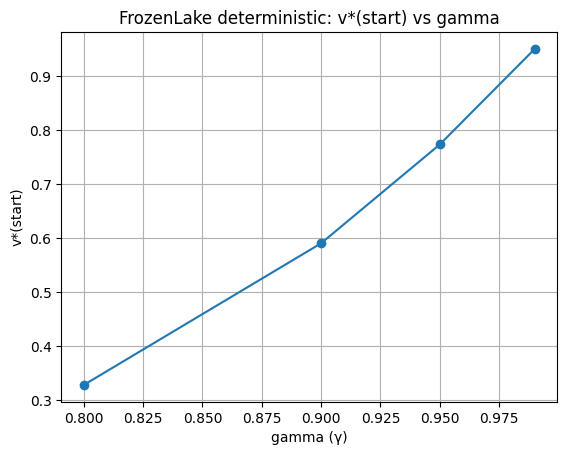

In [27]:
# Analogicznie do podanych niżeej przykładów:

gammas = [0.8, 0.9, 0.95, 0.99]
vstarts = []

for g in gammas:
    pi_star, v_star = value_iteration(P_fl_det, gamma=g)
    vstarts.append(float(v_star[start_state]))

plt.figure()
plt.plot(gammas, vstarts, marker='o')
plt.xlabel("gamma (γ)")
plt.ylabel("v*(start)")
plt.title("FrozenLake deterministic: v*(start) vs gamma")
plt.grid(True)
plt.show()

**Wynik eksperymentu A**:
- dla γ=0.8 → v*(start) jest najniższe. Agent „ignoruje” odległe nagrody, więc wartość startowa jest niewielka
- dla γ=0.9 i γ=0.95 → v*(start) rośnie, bo agent coraz bardziej uwzględnia przyszłe nagrody w planowaniu
- dla γ=0.99 → v*(start) osiąga najwyższą wartość, bo przyszłe nagrody praktycznie w pełni wpływają na decyzje od samego startu.

**Wnioski dla eksperymentu A**:
- eksperyment potwierdza hipotezę — zwiększenie γ rośnie wartość startową v*(start), a przy bardzo małych gamma preferowane są szybkie, krótkoterminowe nagrody
- polityka optymalna może się minimalnie zmienić przy małych γ, bo agent wybiera akcje dające szybką nagrodę zamiast drogi prowadzącej do celu

### Pytanie B — deterministyczne vs slippery (FrozenLake)
**Hipoteza do sprawdzenia:** stochastyczność (`slippery=True`) obniża `v*(start)` i może zmienić `π*`.

Porównaj:
- `P_fl_det` vs `P_fl_slip` (dla tego samego `γ`).

**Wykres:** dwa punkty/kolumny (det vs slippery) dla `v*(start)` (albo dwa przebiegi vs γ).

In [28]:
# Inicjalizacja P_fl_slip
P_fl_slip, _, _, _, _, _ = build_frozenlake_P(desc4, is_slippery=True)

print('FrozenLake (slippery): nS=', nS_fl, ' nA=', nA_fl, ' shape=', (nrow_fl, ncol_fl))
print('FrozenLake map:')
print('\n'.join(''.join(row) for row in desc_fl))

FrozenLake (slippery): nS= 16  nA= 4  shape= (4, 4)
FrozenLake map:
SFFF
FHFH
FFFH
HFFG


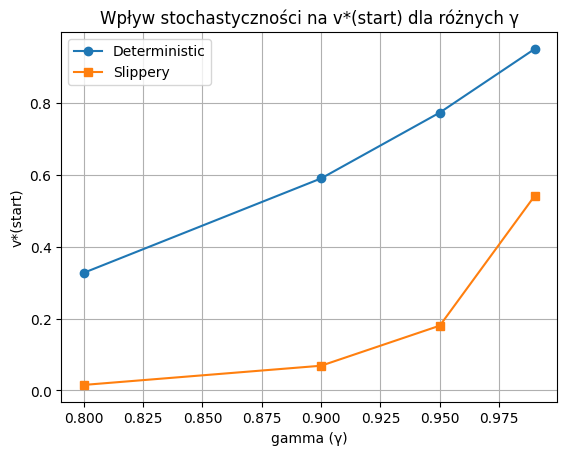

In [29]:
vstarts_det = []
vstarts_slip = []

for g in gammas:
    # Deterministyczne
    pi_star, v_star = value_iteration(P_fl_det, gamma=g)
    vstarts_det.append(float(v_star[start_state]))

    # Slippery
    pi_star, v_star = value_iteration(P_fl_slip, gamma=g)
    vstarts_slip.append(float(v_star[start_state]))

# Wykres
plt.plot(gammas, vstarts_det, marker='o', label='Deterministic')
plt.plot(gammas, vstarts_slip, marker='s', label='Slippery')
plt.xlabel("gamma (γ)")
plt.ylabel("v*(start)")
plt.title("Wpływ stochastyczności na v*(start) dla różnych γ")
plt.legend()
plt.grid(True)
plt.show()

**Wynik eksperymentu B**:
- dla każdej wartości γ v*(start) w wersji slippery jest niższe niż w deterministycznej

**Wnioski dla eksperymentu B**:
- γ v*(start) w wersji slippery jest niższe niż w deterministycznej, co potwierdza hipotezę, że stochastyczność zmniejsza oczekiwaną wartość startową
- π* w wersji slippery mogą być bardziej „ostrożne”, np. unikają akcji prowadzących w pobliże dziur, co jest mniej istotne w deterministycznej wersji

## Co oznacza dokładnie `v(start)` i jak policzyć (powtórzenie powtórzenia :) )?

`v(start)` to **wartość stanu startowego** (czyli wartość funkcji wartości w stanie, od którego zwykle zaczynamy):

$
v(start) = V_\pi(s_{\text{start}})
$

### Definicja (intuicja)
Jeśli zaczynamy w stanie `start` i dalej postępujemy zgodnie z polityką \(\pi\),
to `v(start)` jest **oczekiwaną (zdyskontowaną) sumą przyszłych nagród**:

$
V_\pi(s_{\text{start}})=\mathbb{E}_\pi\left[\sum_{t=0}^{\infty}\gamma^t R_{t+1}\ \middle|\ S_0=s_{\text{start}}\right]
$

Czyli to jedna liczba, która odpowiada na pytanie:

> **„Jak dobry jest ten sposób działania (polityka), jeśli zaczynam od stanu startowego?”**

---

## Jak interpretować `v(start)` w naszych środowiskach?

### 1) FrozenLake (epizodyczne, nagroda na końcu)
W FrozenLake nagroda jest zwykle:
- `+1` za wejście na pole `G` (goal),
- `0` w pozostałych przypadkach,
- epizod kończy się na `H` (hole) lub `G`.

W takim układzie `v(start)` można interpretować jako:

> **zdyskontowaną “szansę sukcesu”** (dotarcia do celu), uwzględniając ryzyko i γ.

- `slippery=True` obniża `v(start)`, bo ruch jest mniej kontrolowalny → częściej kończysz w dziurze.
- większe `γ` sprawia, że bardziej „opłaca się” dążyć do odległego celu (mniej karzesz opóźnienie).

### 2) Gridworld (ciągłe / continuing)
W Gridworld nagrody mogą pochodzić z:
- teleportów/specjalnych pól (dodatnie nagrody),
- kar za wyjście poza planszę (np. -1),
- ewentualnie kosztu kroku (jeśli go dodasz).

Wtedy `v(start)` mówi:

> **jakiego długoterminowego zysku (lub kosztu) oczekujemy**, startując z lewego górnego rogu (lub innego startu), jeśli działamy wg danej polityki.

---

## Dlaczego `v(start)` jest przydatne?

To **jedna liczba** (prosty wskaźnik), dzięki której można:
- porównywać różne polityki (losowa vs optymalna),
- porównywać różne ustawienia środowiska (np. `slippery`),
- porównywać różne parametry (`γ`, kary, nagrody teleportów),
- robić wykresy typu: *parametr → jakość zachowania*.

W praktyce to DP-odpowiednik „średniego returnu” znanego z RL,
tylko że tu liczymy go z modelu (bez próbkowania epizodów).

---

## Jak policzyć `v(start)` w notebooku?

Zakładamy, że masz:
- `v` jako wektor wartości stanów (np. wynik policy/value iteration albo policy evaluation),
- `start_state` (u nas zwykle `0`).

Wtedy (po dowolnej metodzie ___ iteration):

```python
v_start = float(v[start_state])
print("v(start) =", v_start)
```

## Przykład rozgrzewkowy (template): wpływ γ na `v*(start)` w FrozenLake

### W tym przykładzie **Krok 1 i Krok 2 są już wykonane**:
- środowisko jest wybrane (`P_fl_slip`),
- w każdej iteracji liczymy optimum (`π*`, `v*`) metodą `value_iteration`.

Poniższy kod jest **wzorcem**, który skopiujesz później dla Gridworld.
Przyjmujemy konwencję `start_state = 0` (lewy górny róg / pole `S`).


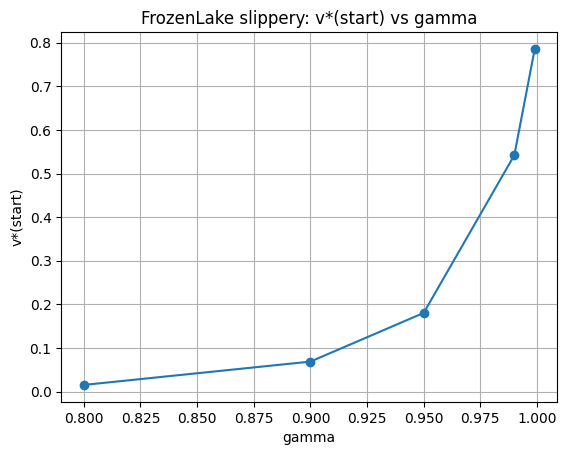

[(0.8, 0.01543433835885007), (0.9, 0.06889090420332247), (0.95, 0.18047157730954727), (0.99, 0.5420259303624805), (0.999, 0.7855332543940133)]


In [30]:
import matplotlib.pyplot as plt
import numpy as np

gammas = [0.8, 0.9, 0.95, 0.99,0.999]
vstarts = []

start_state = 0
for g in gammas:
    pi_star, v_star = value_iteration(P_fl_slip, gamma=g, theta=1e-10)
    vstarts.append(float(v_star[start_state]))

plt.figure()
plt.plot(gammas, vstarts, marker='o')
plt.xlabel("gamma")
plt.ylabel("v*(start)")
plt.title("FrozenLake slippery: v*(start) vs gamma")
plt.grid(True)
plt.show()

print(list(zip(gammas, vstarts)))


## Przykładowa ścieżka rozwiązania pytania badawczego A (porównawcze): Jak `γ` działa w zadaniu epizodycznym vs continuing?
W ramach projektu można po prostu ją przeprowadzić wg opisu (prawie gotowe :) )
tylko trzeba przeprowadzić te eksperymety, zrozumieć i opisać swoimi słowami.

### Cel
Porównaj wpływ parametru dyskontowania `γ` na `v*(start)` w dwóch różnych typach zadań:

- **FrozenLake** (epizodyczne): nagroda jest na końcu epizodu (dotarcie do `G`)
- **Gridworld** (continuing): proces trwa bez końca (zbieramy nagrody w nieskończonym horyzoncie)

### Dlaczego to jest ciekawe?
`γ` kontroluje, jak mocno cenisz przyszłość.  
W epizodycznym zadaniu jego wpływ wygląda inaczej niż w continuing, bo:
- w FrozenLake nagroda zwykle pojawia się po kilku krokach (krótka trajektoria),
- w Gridworld liczy się „długoterminowe zachowanie” w nieskończonym horyzoncie.

### Co mierzymy
Dla każdej wartości `γ` liczymy:
- `v*(start)` w FrozenLake (det lub slippery),
- `v*(start)` w Gridworld.

Następnie robimy wykres:
- oś X: `γ`,
- oś Y: `v*(start)`.

### Zakres γ (proponowany)
Użyj np. listy:
`gammas = [0.8, 0.9, 0.95, 0.99]`

> Uwaga: w continuing zadaniach DP zakładamy `γ < 1`, bo wtedy operator Bellmana jest kontrakcją
> i wartości są dobrze określone.

---

## Przykład (wzór implementacyjny) — wykonany dla FrozenLake

Poniższa komórka pokazuje, jak zrobić sweep po `γ` dla jednego środowiska.  
W kolejnym kroku zastosujesz ten sam wzór dla Gridworld.


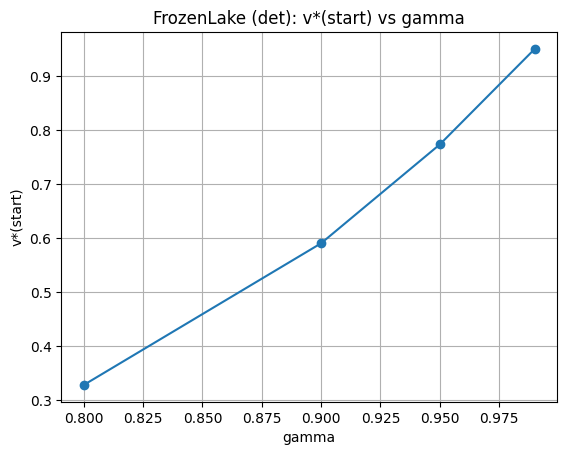

[(0.8, 0.32768000000000014), (0.9, 0.5904900000000002), (0.95, 0.7737809374999999), (0.99, 0.9509900498999999)]


In [31]:
import matplotlib.pyplot as plt

gammas = [0.8, 0.9, 0.95, 0.99]
start_state = 0

vstarts_fl = []
for g in gammas:
    pi_star, v_star = value_iteration(P_fl_det, gamma=g, theta=1e-10)
    vstarts_fl.append(float(v_star[start_state]))

plt.figure()
plt.plot(gammas, vstarts_fl, marker='o')
plt.xlabel("gamma")
plt.ylabel("v*(start)")
plt.title("FrozenLake (det): v*(start) vs gamma")
plt.grid(True)
plt.show()

print(list(zip(gammas, vstarts_fl)))


## Twoje zadanie: zrób to samo dla Gridworld i porównaj

1) Powtórz sweep po `γ` dla **Gridworld** (ten sam `gammas`, ten sam `start_state=0`).
2) Zrób jeden wspólny wykres z dwiema krzywymi:
   - FrozenLake (det lub slippery),
   - Gridworld.

### Kod (szablon — uzupełnij tylko brakujące fragmenty)


In [32]:
# Metoda do budowy GridWorld z poprzedniego notebooka
def build_gridworld_AB_P():
    """Gridworld 5x5 z A/B teleportami (jak w rozdz. 3).

    Akcje (dla Gridworld): 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT.
    Przejścia są deterministyczne: P[s][a] ma jeden wpis z p=1.0.

    Zwraca: P, nS, nA, nrow, ncol
    """
    nrow, ncol = 5, 5
    nS, nA = nrow * ncol, 4
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    # Specjalne pozycje A/B
    A = (0, 1); Aprime = (4, 1); reward_A = 10.0
    B = (0, 3); Bprime = (2, 3); reward_B = 5.0

    def s2pos(s):
        return (s // ncol, s % ncol)

    def pos2s(r, c):
        return r * ncol + c

    moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

    for s in range(nS):
        r, c = s2pos(s)

        # teleporty mają priorytet
        if (r, c) == A:
            s2 = pos2s(*Aprime)
            for a in range(nA):
                P[s][a] = [(1.0, s2, reward_A, False)]
            continue
        if (r, c) == B:
            s2 = pos2s(*Bprime)
            for a in range(nA):
                P[s][a] = [(1.0, s2, reward_B, False)]
            continue

        # standardowe ruchy + kara za wyjście poza planszę
        for a in range(nA):
            dr, dc = moves[a]
            r2, c2 = r + dr, c + dc
            if (r2 < 0) or (r2 >= nrow) or (c2 < 0) or (c2 >= ncol):
                s2 = s
                reward = -1.0
            else:
                s2 = pos2s(r2, c2)
                reward = 0.0
            P[s][a] = [(1.0, s2, reward, False)]

    return P, nS, nA, nrow, ncol

In [34]:
# Inicjalizacja GridWorld
P_gw, nS_gw, nA_gw, nrow_gw, ncol_gw = build_gridworld_AB_P()

print('Gridworld: nS=', nS_gw, ' nA=', nA_gw, ' shape=', (nrow_gw, ncol_gw))
arrows_gw = {0:'↑', 1:'→', 2:'↓', 3:'←'}  # Gridworld: UP, RIGHT, DOWN, LEFT

Gridworld: nS= 25  nA= 4  shape= (5, 5)


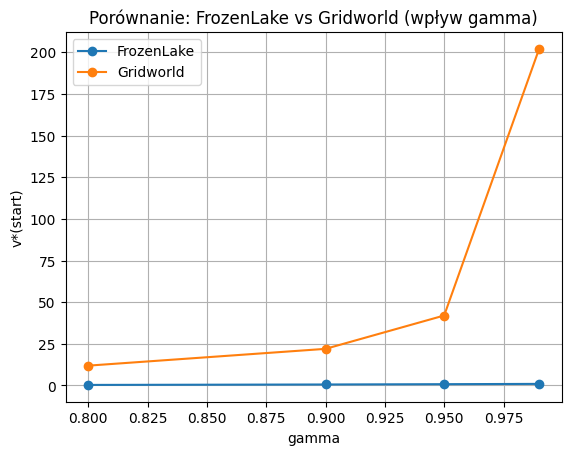

FrozenLake: [(0.8, 0.32768000000000014), (0.9, 0.5904900000000002), (0.95, 0.7737809374999999), (0.99, 0.9509900498999999)]
Gridworld: [(0.8, 11.899095668643895), (0.9, 21.977485287159247), (0.95, 41.99469264404136), (0.99, 201.99979758611693)]


In [35]:
vstarts_gw = []
for g in gammas:
    pi_star, v_star = value_iteration(P_gw, gamma=g)
    vstarts_gw.append(float(v_star[start_state]))

plt.figure()
plt.plot(gammas, vstarts_fl, marker='o', label="FrozenLake")
plt.plot(gammas, vstarts_gw, marker='o', label="Gridworld")
plt.xlabel("gamma")
plt.ylabel("v*(start)")
plt.title("Porównanie: FrozenLake vs Gridworld (wpływ gamma)")
plt.grid(True)
plt.legend()
plt.show()

print("FrozenLake:", list(zip(gammas, vstarts_fl)))
print("Gridworld:", list(zip(gammas, vstarts_gw)))


## Pytania do analizy
1) Jak zmienia się `v*(start)` wraz z `γ` w FrozenLake?  
   (Podpowiedź: w det często widać zależność ~ `γ^L`, gdzie L to długość najlepszej ścieżki.)
   - v*(start) rośnie wraz z γ
   - w wersji deterministycznej zależność jest bliska ~γ^L, gdzie L to długość najkrótszej ścieżki do celu (epizodyczne zadanie)

2) Jak wygląda wpływ `γ` w Gridworld? Czy jest „silniejszy” / „słabszy” niż w FrozenLake?
   - v*(start) również rośnie wraz z γ
   - efekt jest silniejszy niż w FrozenLake

3) Dlaczego te dwa światy zachowują się inaczej?  
   Użyj pojęć: epizodyczne vs continuing, horyzont czasowy, nagroda na końcu vs nagrody w nieskończonym czasie.
   - FrozenLake jest epizodyczne, kończy się po dotarciu do celu lub wpadnięciu w dziurę, więc horyzont jest ograniczony, a nagroda pojawia się tylko na końcu
   - Gridworld jest continuing, nagrody są powtarzalne, więc długoterminowe dyskontowanie γ ma większy wpływ na v*

4) Czy przy bardzo dużym `γ` wartości w Gridworld robią się bardzo duże?  
   Jeśli tak, co to mówi o naturze continuing zadań i roli dyskontowania?
   - przy bardzo dużym γ w Gridworld wartości startowe rosną znacznie, ponieważ agent niemal w pełni uwzględnia przyszłe powtarzalne nagrody. Pokazuje to, że w continuing γ reguluje „wagę przyszłych nagród” i zapobiega formalnie nieskończonym wartościom
